In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
import sklearn
import statsmodels

# Read the data as an appropriate Time Series data and plot the data.

In [2]:
df = pd.read_csv('Sparkling.csv', parse_dates=True, index_col='YearMonth')
df.head()

,Sparkling
YearMonth,
1980-01-01,1686
1980-02-01,1591
1980-03-01,2304
1980-04-01,1712
1980-05-01,1471


In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,8

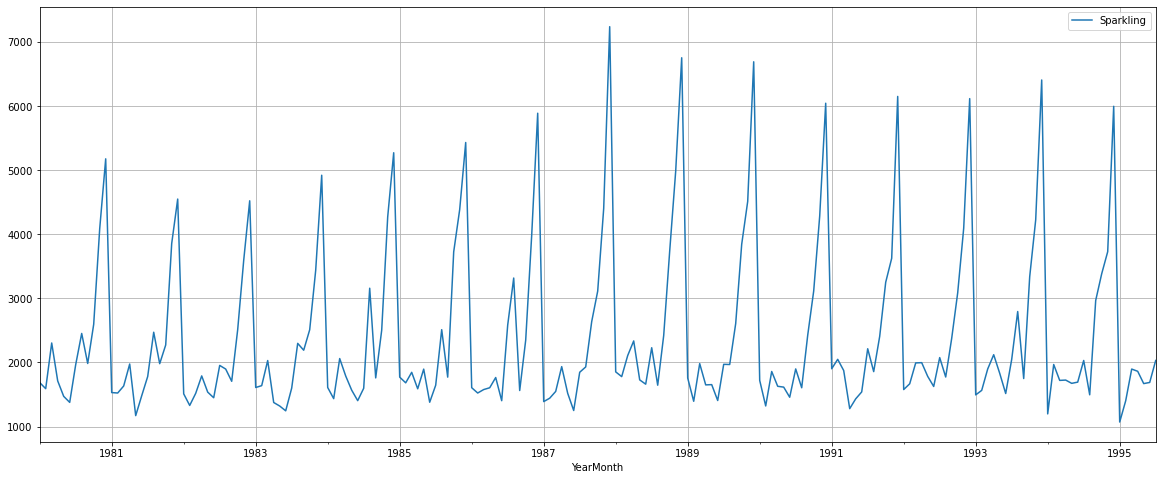

In [4]:
df.plot(grid=True);

# Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sparkling  187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


In [6]:
df.describe()

,Sparkling
count,187.000000
mean,2402.417112
std,1295.111540
min,1070.000000
25%,1605.000000
50%,1874.000000
75%,2549.000000
max,7242.000000


<AxesSubplot:xlabel='Sparkling'>

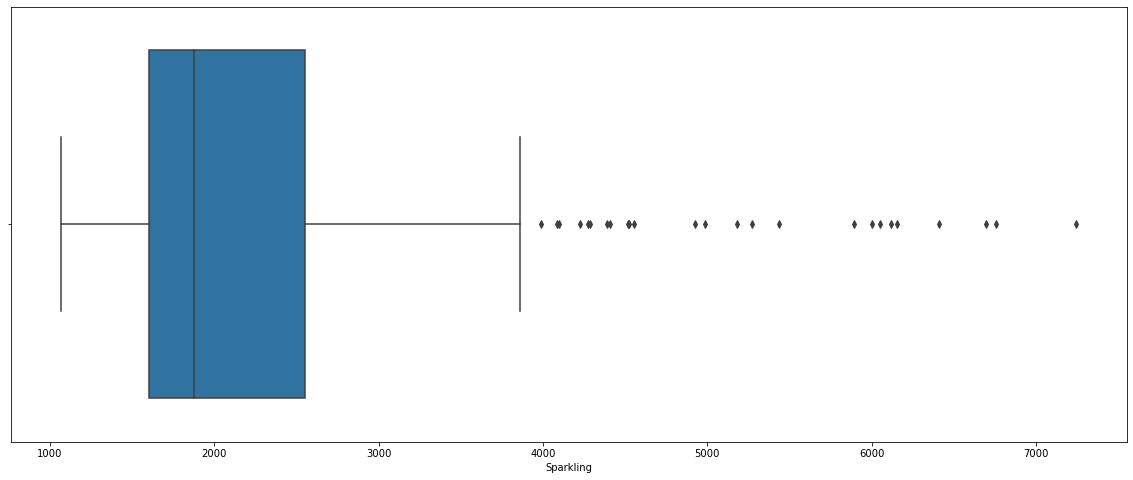

In [7]:
sns.boxplot(data=df, x='Sparkling')

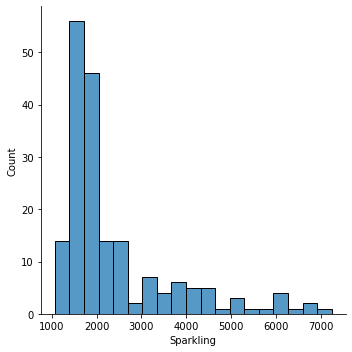

In [8]:
sns.displot(data=df, x='Sparkling')

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Additive Decomposition

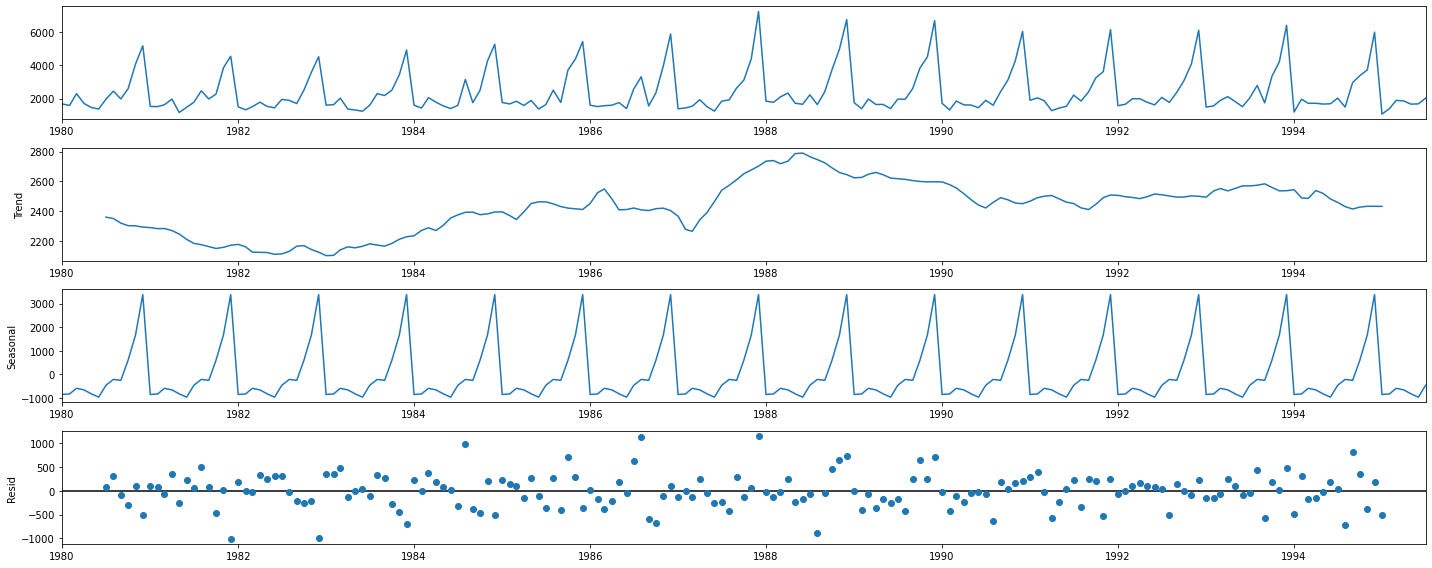

In [10]:
decomposition = seasonal_decompose(df,model='additive')
decomposition.plot();

We see that the residuals have a pattern in this decomposition.

### Multiplicative Decomposition

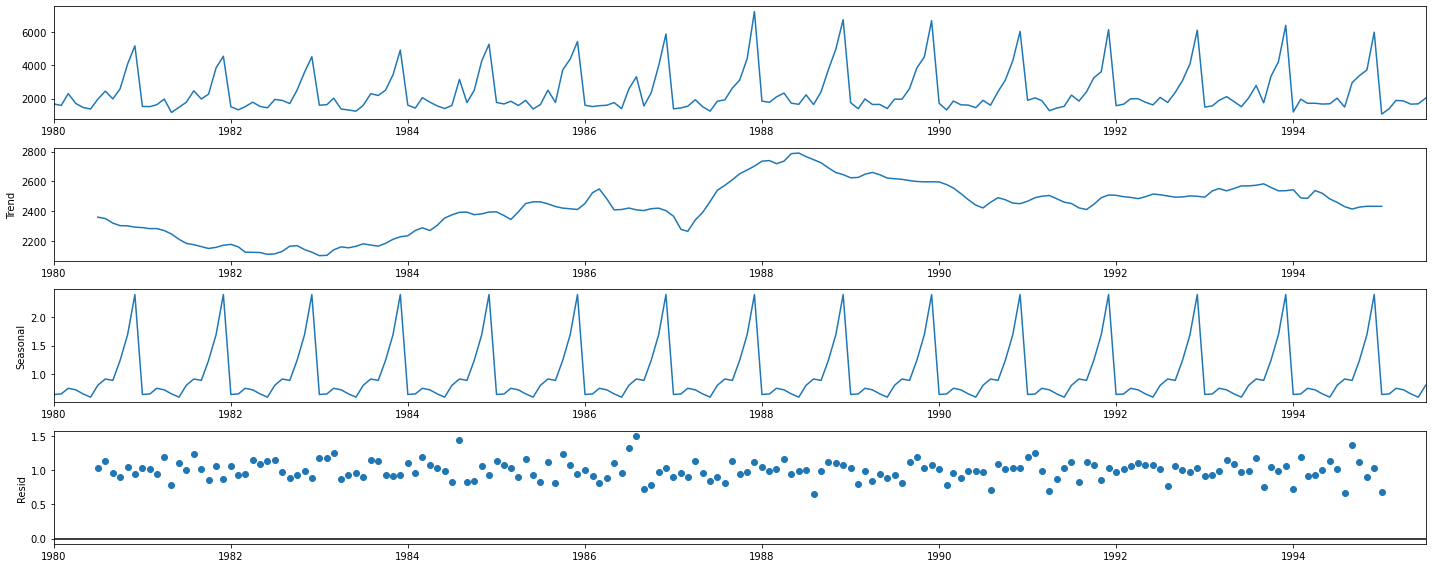

In [11]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot();

For the multiplicative series, we see that a lot of residuals are located around 1.

# Split the data into training and test. The test data should start in 1991.

In [12]:
train = df[df.index<='1990'] 
test = df[df.index>'1990']

# Build all the exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models such as regression,naïve forecast models and simple average models. should also be built on the training data and check the performance on the test data using RMSE.

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import  mean_squared_error
from sklearn.linear_model import LinearRegression

## Linear regression

In [14]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [15]:
lr = LinearRegression()

In [16]:
LinearRegression_train['x'] = [i+1 for i in range(len(train))]
LinearRegression_test['x'] = [i+len(train)+1 for i in range(len(test))]

In [17]:
lr.fit(LinearRegression_train[['x']],LinearRegression_train['Sparkling'])

LinearRegression()

In [18]:
test_predictions_model1 = lr.predict(LinearRegression_test[['x']])
LinearRegression_test['Pred'] = test_predictions_model1

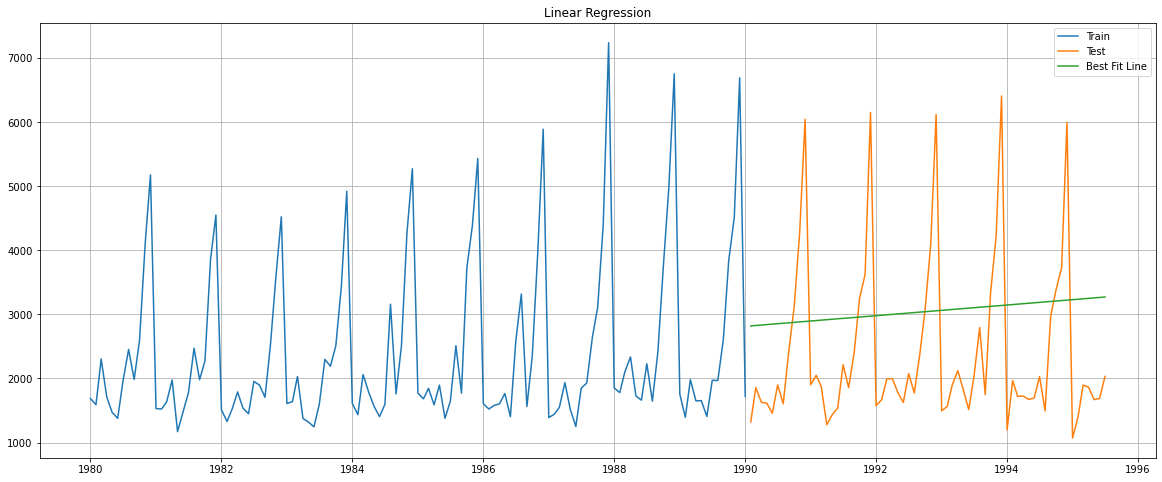

In [19]:
plt.plot(LinearRegression_train['Sparkling'], label='Train')
plt.plot(LinearRegression_test['Sparkling'], label='Test')
plt.plot(LinearRegression_test['Pred'], label='Best Fit Line')
plt.legend(loc='best')
plt.grid()
plt.title('Linear Regression');

In [20]:
resultsDf = pd.DataFrame({'RMSE': [mean_squared_error(LinearRegression_test['Sparkling'].values,LinearRegression_test['Pred'].values,squared=False)]},index=['LR'])
resultsDf

,RMSE
LR,1446.976417


## Naive Model

In [21]:
Naive_train = train.copy()
Naive_test = test.copy()

In [22]:
Naive_test["Naive_Pred"] = Naive_train['Sparkling'][-1]

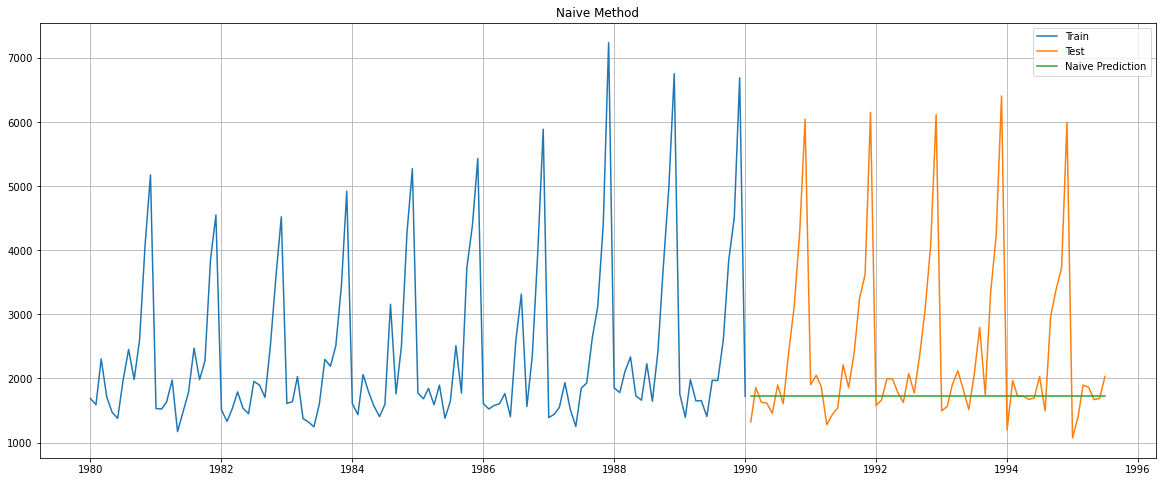

In [23]:
plt.plot(Naive_train['Sparkling'], label='Train')
plt.plot(Naive_test['Sparkling'], label='Test')
plt.plot(Naive_test['Naive_Pred'], label='Naive Prediction')
plt.legend(loc='best')
plt.grid()
plt.title('Naive Method');

In [24]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(Naive_test['Sparkling'].values,Naive_test['Naive_Pred'].values,squared=False)]},index=['Naive'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976


## Simple Average Method

In [25]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [26]:
SimpleAverage_test['mean_forecast'] = SimpleAverage_train['Sparkling'].mean()

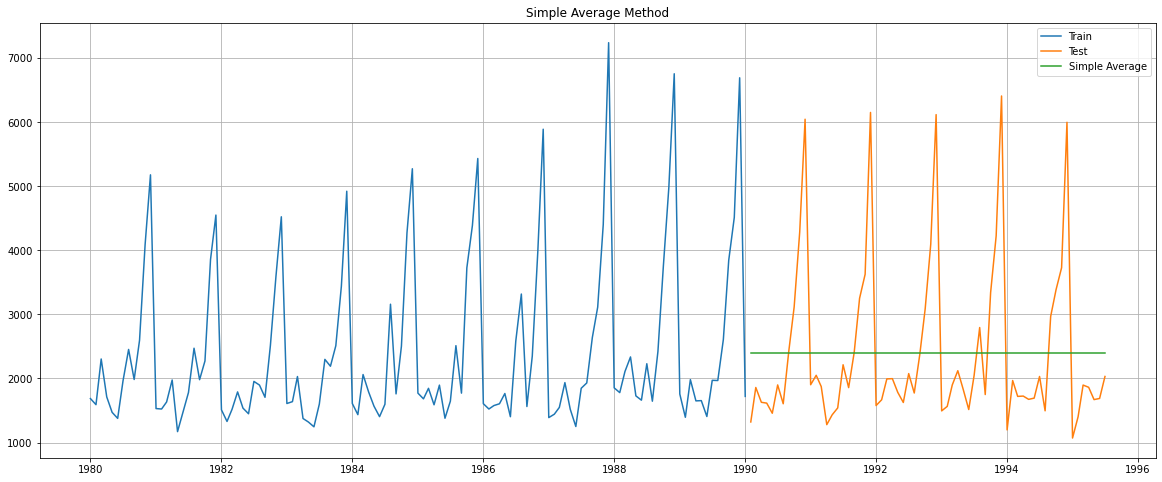

In [27]:
plt.plot(SimpleAverage_train['Sparkling'], label='Train')
plt.plot(SimpleAverage_test['Sparkling'], label='Test')
plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average')
plt.legend(loc='best')
plt.grid()
plt.title('Simple Average Method');

In [28]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(SimpleAverage_test['Sparkling'].values,SimpleAverage_test['mean_forecast'].values,squared=False)]},index=['Average'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976
Average,1298.234937


### SES -  ETS(A, N, N) - Simple Exponential Smoothing with additive errors

In [29]:
model_SES = SimpleExpSmoothing(train,initialization_method='estimated')
model_SES_autofit = model_SES.fit(optimized=True)
model_SES_autofit.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.04846796208138457,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 2154.83754179656,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [30]:
SES_predict = model_SES_autofit.forecast(steps=len(test))
SES_predict

1990-02-01    2761.674023
1990-03-01    2761.674023
1990-04-01    2761.674023
1990-05-01    2761.674023
1990-06-01    2761.674023
                 ...     
1995-03-01    2761.674023
1995-04-01    2761.674023
1995-05-01    2761.674023
1995-06-01    2761.674023
1995-07-01    2761.674023
Freq: MS, Length: 66, dtype: float64

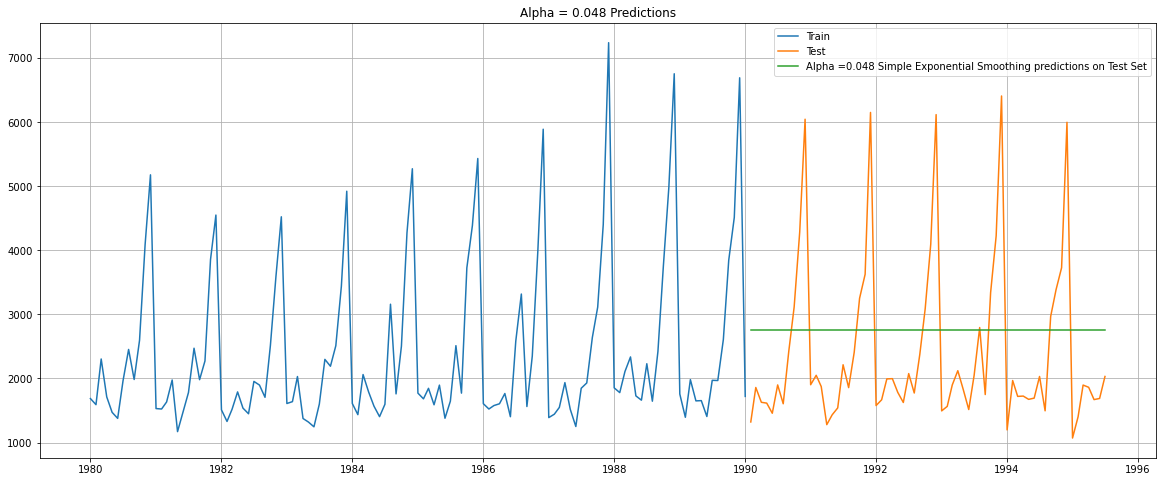

In [31]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(SES_predict, label='Alpha =0.048 Simple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Alpha = 0.048 Predictions');

In [32]:
print('SES RMSE:',mean_squared_error(test.values,SES_predict.values,squared=False))

SES RMSE: 1344.344904142188


In [33]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,SES_predict.values,squared=False)]},index=['SES (0.048)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976
Average,1298.234937
SES (0.048),1344.344904


## Holt - ETS(A, A, N) - Holt's linear method with additive errors

In [34]:
model_DES = Holt(train,initialization_method='estimated')
model_DES = model_DES.fit()
model_DES.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{'smoothing_level': 0.07614004553916748,
 'smoothing_trend': 0.07614004553916748,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1505.7542720297138,
 'initial_trend': 3.4694474222772413,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [35]:
DES_predict =  model_DES.forecast(len(test))
DES_predict

1990-02-01    3003.389755
1990-03-01    3026.885882
1990-04-01    3050.382009
1990-05-01    3073.878136
1990-06-01    3097.374262
                 ...     
1995-03-01    4436.653488
1995-04-01    4460.149615
1995-05-01    4483.645742
1995-06-01    4507.141869
1995-07-01    4530.637995
Freq: MS, Length: 66, dtype: float64

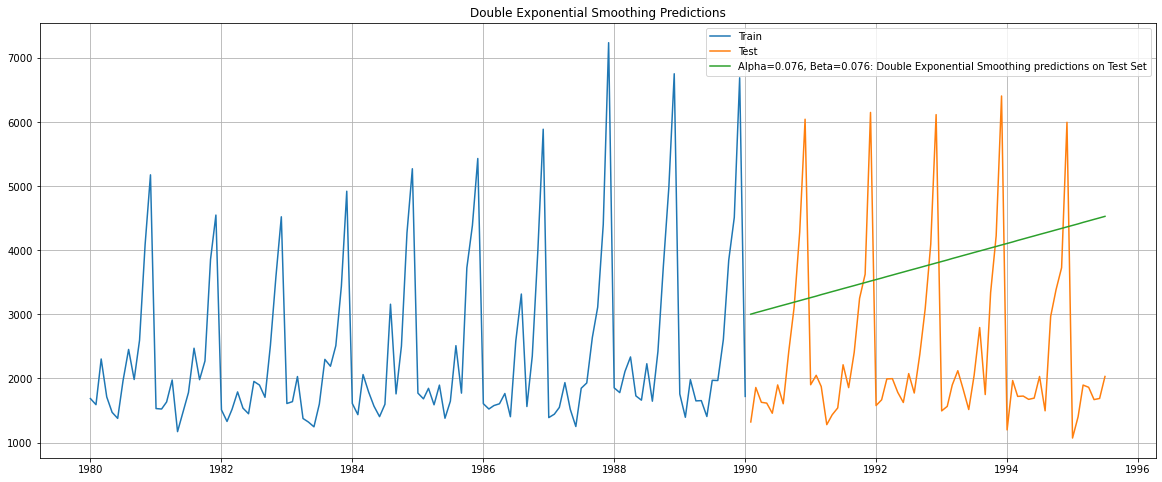

In [36]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(DES_predict, label='Alpha=0.076, Beta=0.076: Double Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Double Exponential Smoothing Predictions');

In [37]:
print('DES RMSE:',mean_squared_error(test.values,DES_predict.values,squared=False))

DES RMSE: 1919.7819179744936


In [38]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,DES_predict.values,squared=False)]}, index=['DES ((0.076, 0.076))'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976
Average,1298.234937
SES (0.048),1344.344904
"DES ((0.076, 0.076))",1919.781918


### Holt-Winters - ETS(A, A, A) - Holt Winter's linear method with additive errors

In [39]:
model_TES = ExponentialSmoothing(train,trend='additive',seasonal='additive',initialization_method='estimated')
model_TES = model_TES.fit()
model_TES.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.06835194787892203,
 'smoothing_trend': 0.03514783938878143,
 'smoothing_seasonal': 0.4344999665656267,
 'damping_trend': nan,
 'initial_level': 2352.5365939141357,
 'initial_trend': -0.5138176879041003,
 'initial_seasons': array([-649.67277743, -733.35225136, -373.708606  , -483.39870273,
        -824.86496767, -831.04466434, -387.30889431,   86.50432256,
        -258.16281806,  265.51429669, 1572.62389503, 2613.03914509]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [40]:
TES_predict =  model_TES.forecast(len(test))
TES_predict

1990-02-01    1609.222202
1990-03-01    2011.935162
1990-04-01    1956.917571
1990-05-01    1773.744067
1990-06-01    1564.843801
                 ...     
1995-03-01    2282.680001
1995-04-01    2227.662410
1995-05-01    2044.488906
1995-06-01    1835.588640
1995-07-01    2434.978962
Freq: MS, Length: 66, dtype: float64

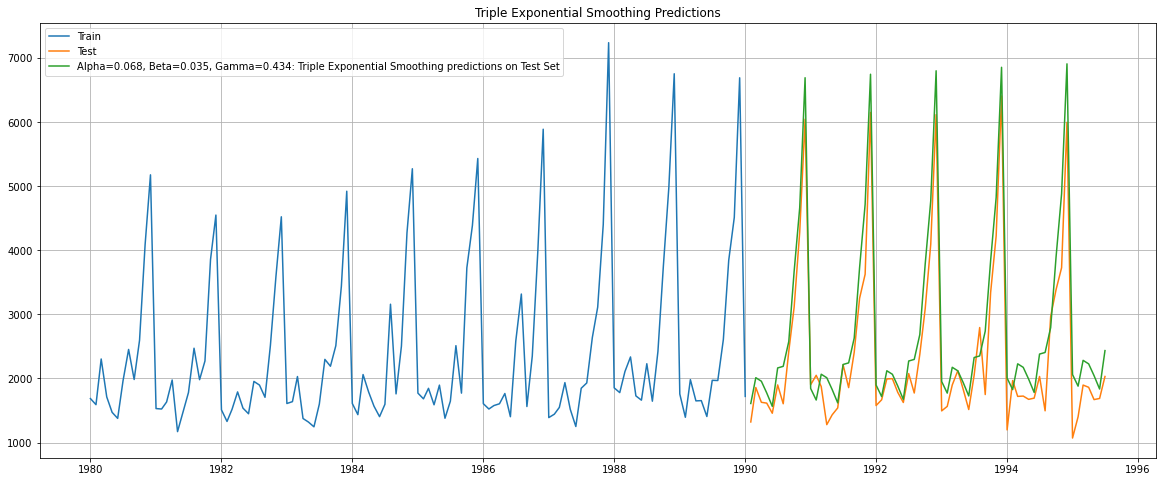

In [41]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(TES_predict, label='Alpha=0.068, Beta=0.035, Gamma=0.434: Triple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Predictions');

In [42]:
print('TES RMSE:',mean_squared_error(test.values,TES_predict.values,squared=False))

TES RMSE: 481.53556611485976


In [43]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,TES_predict.values,squared=False)]}, index=['TES A (0.068, 0.035, 0.43)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976
Average,1298.234937
SES (0.048),1344.344904
"DES ((0.076, 0.076))",1919.781918
"TES A (0.068, 0.035, 0.43)",481.535566


### Holt-Winters - ETS(A, A, M) - Holt Winter's linear method 

In [44]:
model_TES_am = ExponentialSmoothing(train,trend='add',seasonal='multiplicative',initialization_method='estimated')
model_TES_am = model_TES_am.fit()
model_TES_am.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.07573212523451951,
 'smoothing_trend': 0.06491207214032642,
 'smoothing_seasonal': 0.34233164864884574,
 'damping_trend': nan,
 'initial_level': 2356.5277218172982,
 'initial_trend': -9.839004681619393,
 'initial_seasons': array([0.71279614, 0.686421  , 0.89880345, 0.80214863, 0.64934943,
        0.64487895, 0.87573897, 1.12562984, 0.90614413, 1.20985115,
        1.86334588, 2.37052586]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [45]:
TES_predict_am =  model_TES_am.forecast(len(test))
TES_predict_am

1990-02-01    1602.522843
1990-03-01    1979.192585
1990-04-01    1934.285990
1990-05-01    1731.523391
1990-06-01    1503.875286
                 ...     
1995-03-01    2098.414123
1995-04-01    2050.685609
1995-05-01    1835.616954
1995-06-01    1594.192892
1995-07-01    2247.826618
Freq: MS, Length: 66, dtype: float64

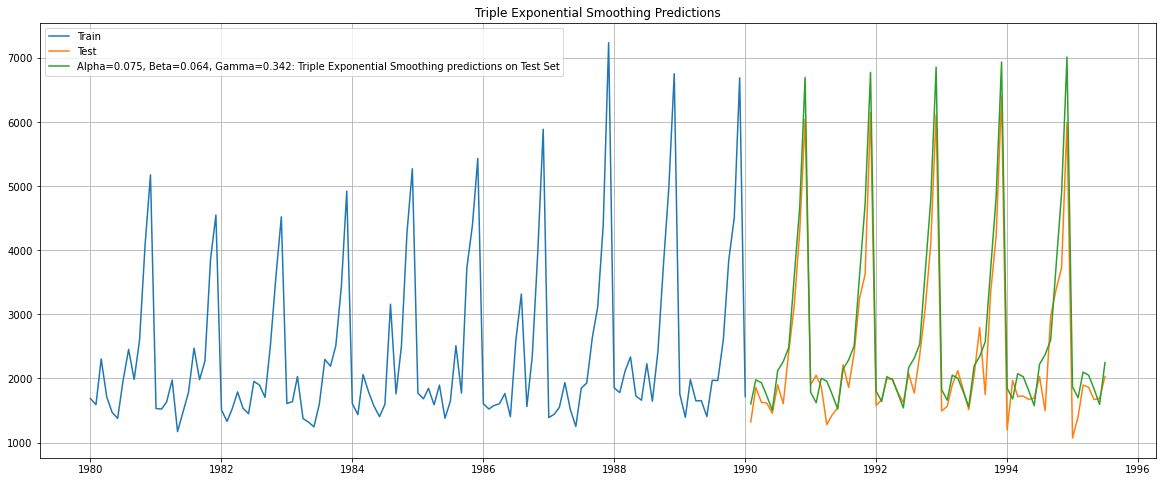

In [46]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(TES_predict_am, label='Alpha=0.075, Beta=0.064, Gamma=0.342: Triple Exponential Smoothing predictions on Test Set')
plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Predictions');

In [47]:
print('TES_am RMSE:',mean_squared_error(test.values,TES_predict_am.values,squared=False))

TES_am RMSE: 441.7269736801131


In [48]:
resultsDf_temp = pd.DataFrame({'RMSE': [mean_squared_error(test.values,TES_predict_am.values,squared=False)]}, index=['TES M (0.075, 0.064, 0.34)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976
Average,1298.234937
SES (0.048),1344.344904
"DES ((0.076, 0.076))",1919.781918
"TES A (0.068, 0.035, 0.43)",481.535566
"TES M (0.075, 0.064, 0.34)",441.726974


# Check for the stationarity of the data on which the model is being built on using appropriate statistical tests and also mention the hypothesis for the statistical test. If the data is found to be non-stationary, take appropriate steps to make it stationary. Check the new data for stationarity and comment. Note: Stationarity should be checked at alpha = 0.05.

The Augmented Dickey-Fuller test is an unit root test which determines whether there is a unit root and subsequently whether the series is non-stationary.

The hypothesis in a simple form for the ADF test is:
* $H_0$ : The Time Series has a unit root and is thus non-stationary.
* $H_1$ : The Time Series does not have a unit root and is thus stationary.

We would want the series to be stationary for building ARIMA models and thus we would want the p-value of this test to be less than the $\alpha$ value.

In [49]:
from statsmodels.tsa.stattools import adfuller

In [50]:
dftest = adfuller(train,regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -2.706
DF test p-value is 0.233470932432705
Number of lags used 12


The training data is non-stationary at 95% confidence level. Let us take a first level of differencing to stationarize the Time Series.

In [51]:
dftest = adfuller(train.diff().dropna(),regression='ct')
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is' ,dftest[1])
print('Number of lags used' ,dftest[2])

DF test statistic is -7.809
DF test p-value is 1.9789011224599453e-10
Number of lags used 11


The differenced training data is stationary at 95% confidence level.
Plotting the differenced training data for visualisation.

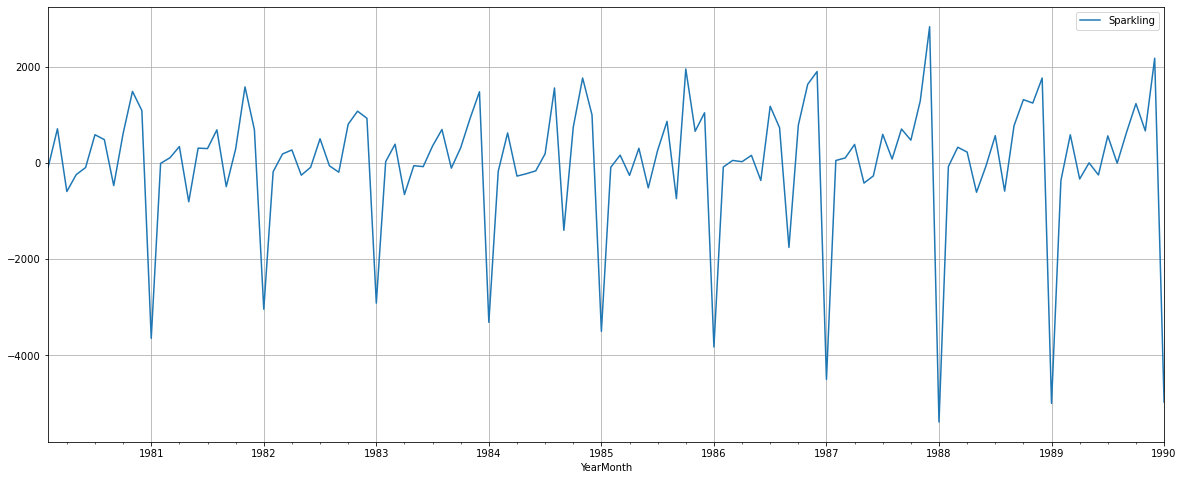

In [52]:
train.diff().dropna().plot(grid=True);

## Build an automated version of the ARIMA/SARIMA model in which the parameters are selected using the lowest Akaike Information Criteria (AIC) on the training data and evaluate this model on the test data using RMSE.

In [53]:
import itertools
p = q = range(0, 4)
d= range(1,2)
pdq = list(itertools.product(p, d, q))
print('Examples of the parameter combinations for the Model')
for i in range(0,len(pdq)):
    print('Model: {}'.format(pdq[i]))

Examples of the parameter combinations for the Model
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (0, 1, 3)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (1, 1, 3)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)
Model: (2, 1, 3)
Model: (3, 1, 0)
Model: (3, 1, 1)
Model: (3, 1, 2)
Model: (3, 1, 3)


In [54]:
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [55]:
from statsmodels.tsa.arima.model import ARIMA

for param in pdq:
    ARIMA_model = ARIMA(train['Sparkling'].values,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param,ARIMA_model.aic))
    ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)

ARIMA(0, 1, 0) - AIC:2084.8013475632715


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(0, 1, 1) - AIC:2068.63987643717
ARIMA(0, 1, 2) - AIC:2048.7264931582495
ARIMA(0, 1, 3) - AIC:2049.373042581908
ARIMA(1, 1, 0) - AIC:2082.692341101697


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

ARIMA(1, 1, 1) - AIC:2050.4519451744395
ARIMA(1, 1, 2) - AIC:2049.861696579987
ARIMA(1, 1, 3) - AIC:2050.631277288253
ARIMA(2, 1, 0) - AIC:2076.0295693825465
ARIMA(2, 1, 1) - AIC:2048.850128321663


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


ARIMA(2, 1, 2) - AIC:2032.2588082239768


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

ARIMA(2, 1, 3) - AIC:2046.4333149331242
ARIMA(3, 1, 0) - AIC:2072.089494611862
ARIMA(3, 1, 1) - AIC:2050.5745069301083


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2) - AIC:2045.7953430233506
ARIMA(3, 1, 3) - AIC:2037.1799496106655


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3609794300.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ARIMA_AIC = ARIMA_AIC.append({'param':param, 'AIC': ARIMA_model.aic}, ignore_index=True)


In [56]:
ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
10,"(2, 1, 2)",2032.258808
15,"(3, 1, 3)",2037.17995
14,"(3, 1, 2)",2045.795343
11,"(2, 1, 3)",2046.433315
2,"(0, 1, 2)",2048.726493


In [57]:
auto_ARIMA = ARIMA(train, order=(2,1,2))
results_auto_ARIMA = auto_ARIMA.fit()
print(results_auto_ARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  121
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1011.129
Date:                Sat, 18 Feb 2023   AIC                           2032.259
Time:                        17:46:53   BIC                           2046.196
Sample:                    01-01-1980   HQIC                          2037.919
                         - 01-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2738      0.051     25.087      0.000       1.174       1.373
ar.L2         -0.5238      0.087     -6.039      0.000      -0.694      -0.354
ma.L1         -1.9914      0.118    -16.892      0.0

Diagnostics plot.

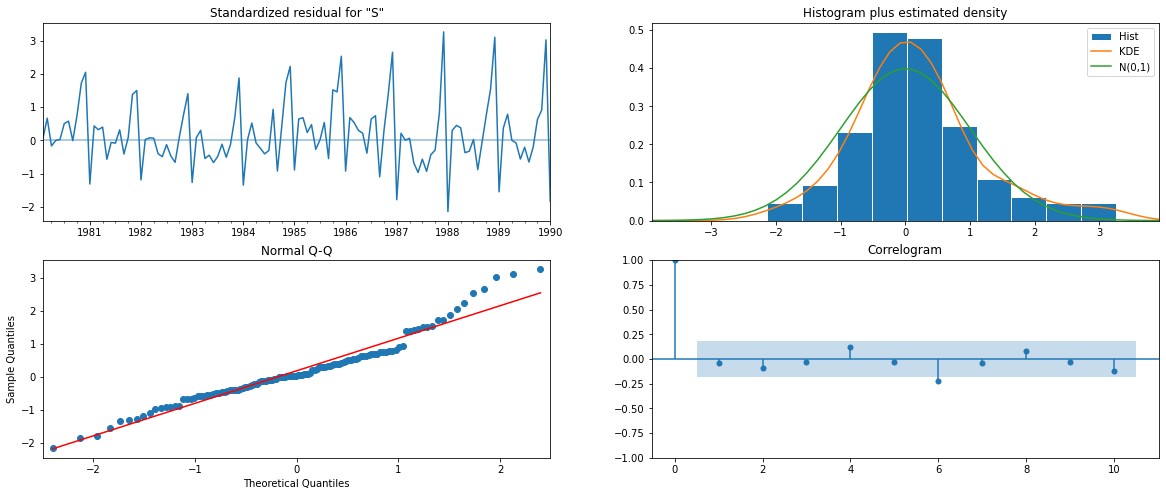

In [58]:
results_auto_ARIMA.plot_diagnostics();

## Predict on the Test Set using this model and evaluate the model.

In [59]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

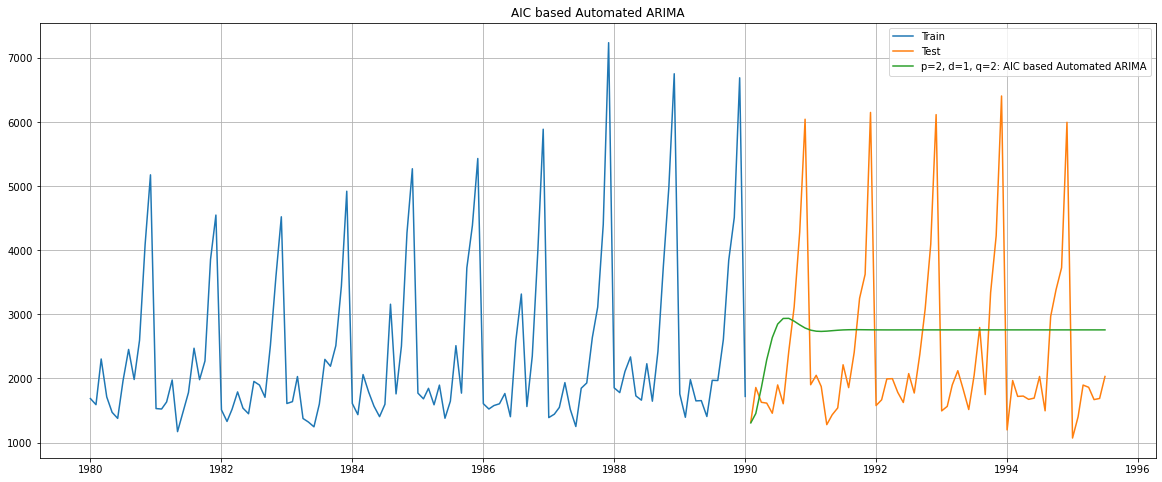

In [60]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_auto_ARIMA, label='p=2, d=1, q=2: AIC based Automated ARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('AIC based Automated ARIMA');

In [61]:
rmse = mean_squared_error(test['Sparkling'],predicted_auto_ARIMA,squared=False)
print('RMSE:',rmse)

RMSE: 1314.9140858161416


In [62]:
resultsDf_temp = pd.DataFrame({'RMSE': rmse}, index=['AUTO ARIMA (2, 1, 2)'])
resultsDf = pd.concat([resultsDf, resultsDf_temp])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976
Average,1298.234937
SES (0.048),1344.344904
"DES ((0.076, 0.076))",1919.781918
"TES A (0.068, 0.035, 0.43)",481.535566
"TES M (0.075, 0.064, 0.34)",441.726974
"AUTO ARIMA (2, 1, 2)",1314.914086


## Build a version of the ARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots.

Let us look at the ACF and the PACF plots.

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

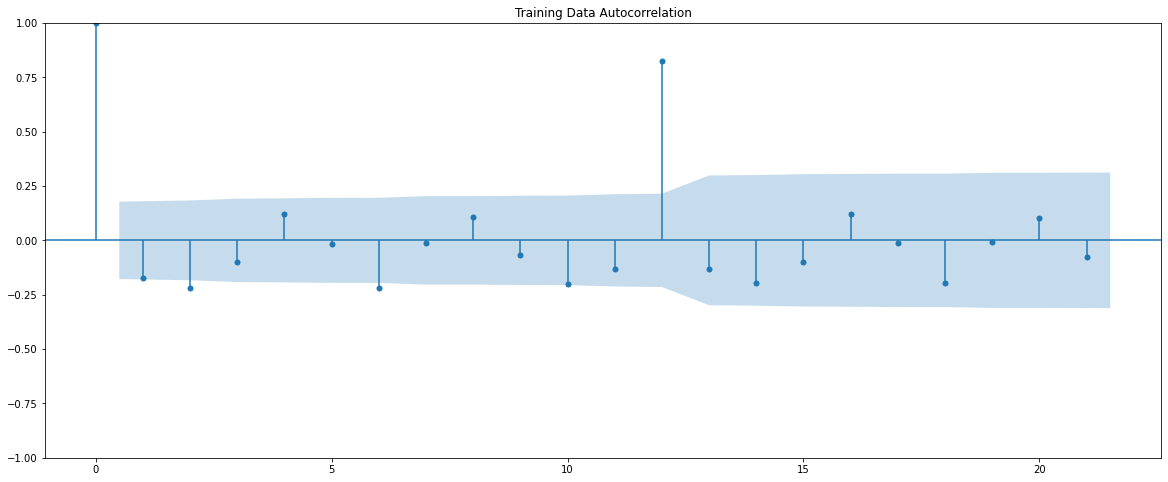

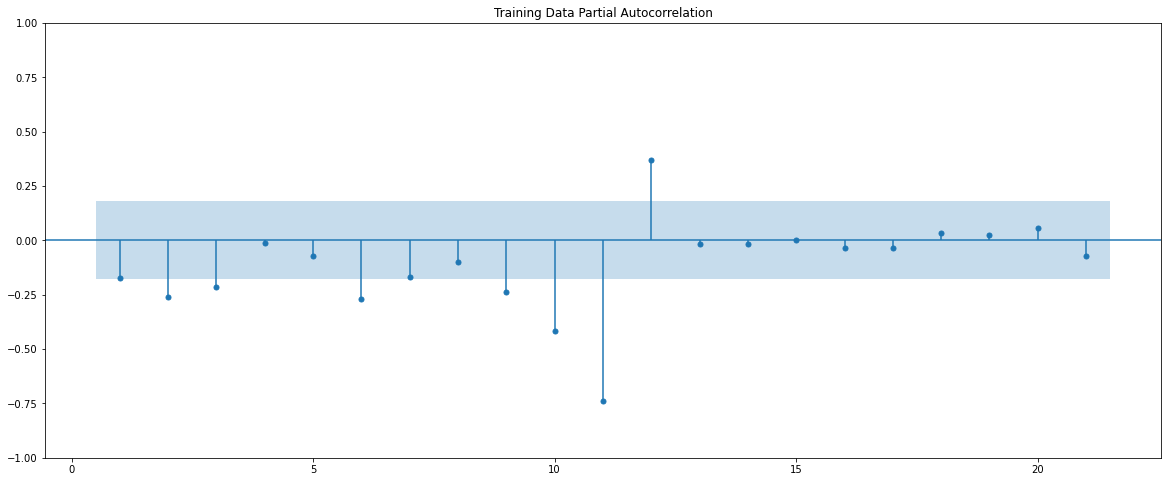

In [64]:
plot_acf(train.diff(),title='Training Data Autocorrelation',missing='drop')
plot_pacf(train.diff().dropna(),title='Training Data Partial Autocorrelation',zero=False,method='ywmle')
plt.show()

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 3.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 2.

By looking at the above plots, we will take the value of p and q to be 3 and 2 respectively.

In [65]:
manual_ARIMA = ARIMA(train['Sparkling'], order=(3,1,2))
results_manual_ARIMA = manual_ARIMA.fit()
print(results_manual_ARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Sparkling   No. Observations:                  121
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1016.898
Date:                Sat, 18 Feb 2023   AIC                           2045.795
Time:                        17:46:54   BIC                           2062.520
Sample:                    01-01-1980   HQIC                          2052.587
                         - 01-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4537      0.131     -3.461      0.001      -0.711      -0.197
ar.L2          0.2975      0.120      2.489      0.013       0.063       0.532
ar.L3         -0.2488      0.192     -1.299      0.1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Let us analyse the residuals from the various diagnostics plot.

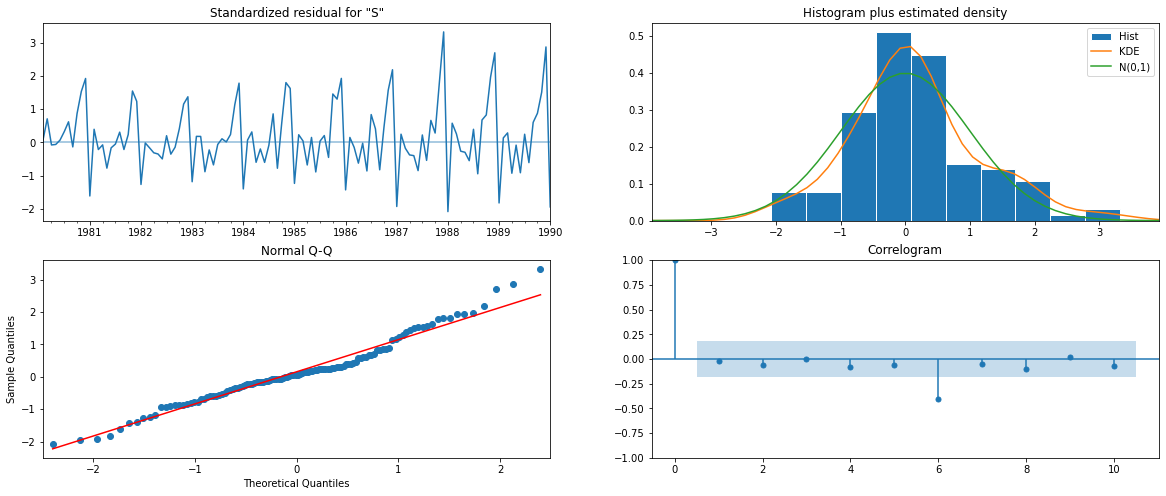

In [66]:
results_manual_ARIMA.plot_diagnostics();

## Predict on the Test Set using this model and evaluate the model.

In [67]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))

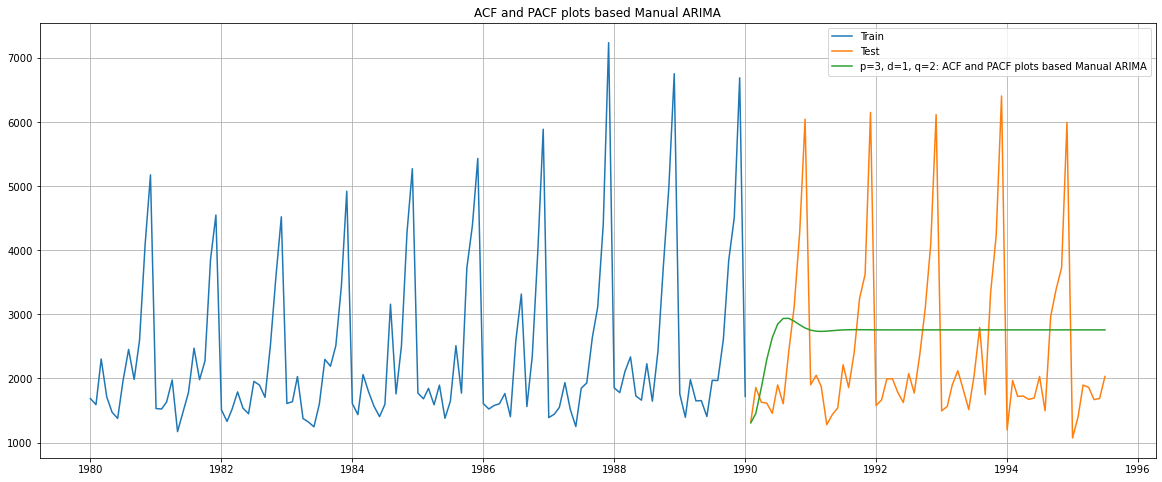

In [68]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_auto_ARIMA, label='p=3, d=1, q=2: ACF and PACF plots based Manual ARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('ACF and PACF plots based Manual ARIMA');

In [69]:
rmse = mean_squared_error(test['Sparkling'],predicted_manual_ARIMA,squared=False)
print('RMSE:',rmse)

RMSE: 1275.0039362093955


In [70]:
temp_resultsDf = pd.DataFrame({'RMSE': rmse}, index=['MANUAL ARIMA (3, 1, 2)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

,RMSE
LR,1446.976417
Naive,1471.197976
Average,1298.234937
SES (0.048),1344.344904
"DES ((0.076, 0.076))",1919.781918
"TES A (0.068, 0.035, 0.43)",481.535566
"TES M (0.075, 0.064, 0.34)",441.726974
"AUTO ARIMA (2, 1, 2)",1314.914086
"MANUAL ARIMA (3, 1, 2)",1275.003936


## Build an Automated version of a SARIMA model for which the best parameters are selected in accordance with the lowest Akaike Information Criteria (AIC).

Let us look at the ACF plot once more to understand the seasonal parameter for the SARIMA model.

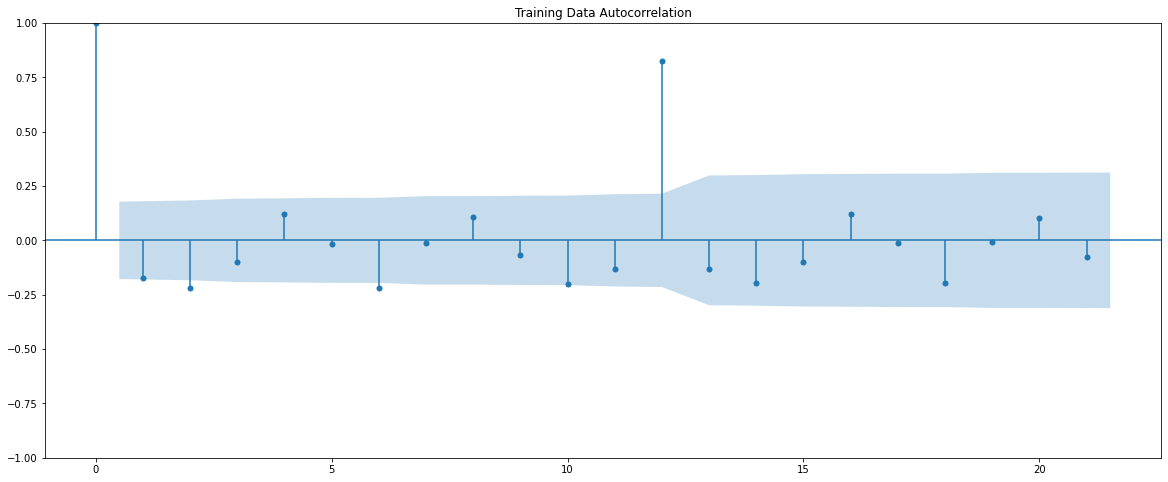

In [71]:
plot_acf(train.diff(),title='Training Data Autocorrelation',missing='drop');

We can see that there is a seasonality.

In [72]:
import itertools
p = q = range(0, 4)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
PDQ = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of the parameter combinations for the Model are')
for i in range(1,len(pdq)):
    print('Model: {}{}'.format(pdq[i], PDQ[i]))

Examples of the parameter combinations for the Model are
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (0, 1, 3)(0, 0, 3, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (1, 1, 3)(1, 0, 3, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)
Model: (2, 1, 3)(2, 0, 3, 12)
Model: (3, 1, 0)(3, 0, 0, 12)
Model: (3, 1, 1)(3, 0, 1, 12)
Model: (3, 1, 2)(3, 0, 2, 12)
Model: (3, 1, 3)(3, 0, 3, 12)


In [73]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [74]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in PDQ:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train['Sparkling'].values,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:2068.437427703135
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1781.9976268042305


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:1551.101300293976


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 0)x(0, 0, 3, 12) - AIC:4126.6773371259005
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1675.9733379990714
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1649.1093719494986
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:1468.9271067556126


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 0)x(1, 0, 3, 12) - AIC:3069.683063830808
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1487.885786330501
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:1487.21146066241


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:1469.3364803653917


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 0)x(2, 0, 3, 12) - AIC:2661.5136963098735
SARIMA(0, 1, 0)x(3, 0, 0, 12) - AIC:1306.1238795308218
SARIMA(0, 1, 0)x(3, 0, 1, 12) - AIC:1307.4417812429217


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 0)x(3, 0, 2, 12) - AIC:1308.3157583285877


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 0)x(3, 0, 3, 12) - AIC:2287.4529460260114
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:2034.9961141467506
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1747.6124880303166


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:1516.4580006661051


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(0, 0, 3, 12) - AIC:3939.8086128746645
SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1637.9064437640864


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1576.0657263691382


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:1404.8994170847584


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(1, 0, 3, 12) - AIC:3657.222930348314
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:1444.815849010702


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:1434.655474725743


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:1405.9005204865573


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(2, 0, 3, 12) - AIC:3063.7950298785245
SARIMA(0, 1, 1)x(3, 0, 0, 12) - AIC:1262.882834987311


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(3, 0, 1, 12) - AIC:1262.0962245374867


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(3, 0, 2, 12) - AIC:1263.0755508164787


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 1)x(3, 0, 3, 12) - AIC:3063.0097160818755
SARIMA(0, 1, 2)x(0, 0, 0, 12) - AIC:1998.3955524498244


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(0, 0, 1, 12) - AIC:1716.1832495659148


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(0, 0, 2, 12) - AIC:1486.8479801491824


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(0, 0, 3, 12) - AIC:3544.4130167203716
SARIMA(0, 1, 2)x(1, 0, 0, 12) - AIC:1631.4914843997244


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:1585.79673571938


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(1, 0, 2, 12) - AIC:1393.1971489181105


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(1, 0, 3, 12) - AIC:3221.55160894712
SARIMA(0, 1, 2)x(2, 0, 0, 12) - AIC:1443.247163672644


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:1436.464710385468


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:1393.1094463974416


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(2, 0, 3, 12) - AIC:2642.0812008488683
SARIMA(0, 1, 2)x(3, 0, 0, 12) - AIC:1264.1117864614885


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(3, 0, 1, 12) - AIC:1263.9950546276589


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 2)x(3, 0, 2, 12) - AIC:1264.6947401141397


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 2)x(3, 0, 3, 12) - AIC:2243.290805353793
SARIMA(0, 1, 3)x(0, 0, 0, 12) - AIC:1984.7114504841525
SARIMA(0, 1, 3)x(0, 0, 1, 12) - AIC:1702.330295870312


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(0, 0, 2, 12) - AIC:1472.175598549672


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(0, 0, 3, 12) - AIC:3319.443039368499
SARIMA(0, 1, 3)x(1, 0, 0, 12) - AIC:1633.3505770371842


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(1, 0, 1, 12) - AIC:1548.2699987236088


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(1, 0, 2, 12) - AIC:1378.0614292324042


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(1, 0, 3, 12) - AIC:2779.9066065798665
SARIMA(0, 1, 3)x(2, 0, 0, 12) - AIC:1443.4843650619268


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(2, 0, 1, 12) - AIC:1436.6633157678848


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(2, 0, 2, 12) - AIC:1378.1585186239736


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(2, 0, 3, 12) - AIC:2167.2934810371203
SARIMA(0, 1, 3)x(3, 0, 0, 12) - AIC:1264.340250710696


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(3, 0, 1, 12) - AIC:1263.6003674011577


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(0, 1, 3)x(3, 0, 2, 12) - AIC:1264.348107539688


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(0, 1, 3)x(3, 0, 3, 12) - AIC:2284.8546993628524
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:2066.3413601803745
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1779.2587005836303


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(0, 0, 2, 12) - AIC:1549.578114262117


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(1, 1, 0)x(0, 0, 3, 12) - AIC:3427.297595588186
SARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:1651.7055909719886
SARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1629.768462538664


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(1, 0, 2, 12) - AIC:1456.7224209611006


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(1, 0, 3, 12) - AIC:3128.1817802236233
SARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:1462.9797235206715


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:1457.87696399103


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:1456.7181015246547


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(2, 0, 3, 12) - AIC:2500.9639913211677
SARIMA(1, 1, 0)x(3, 0, 0, 12) - AIC:1280.8892511099214


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(3, 0, 1, 12) - AIC:1282.1271676346125


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 0)x(3, 0, 2, 12) - AIC:1283.1580915046748


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(1, 1, 0)x(3, 0, 3, 12) - AIC:2549.481424621988
SARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:2019.5435360529875
SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:1734.8267583064865


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(0, 0, 2, 12) - AIC:1507.6158228265667


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(0, 0, 3, 12) - AIC:5051.075445995346
SARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1616.7179937595179


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:1577.6744710719968


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(1, 0, 2, 12) - AIC:1407.1810810137129


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(1, 0, 3, 12) - AIC:664.7623148954963
SARIMA(1, 1, 1)x(2, 0, 0, 12) - AIC:1430.0954018325242


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:1421.8072617265918


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 2, 12) - AIC:1407.5164849520058


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(2, 0, 3, 12) - AIC:2711.663035782085


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(3, 0, 0, 12) - AIC:1296.2628488108433


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(3, 0, 1, 12) - AIC:1296.7033792292627


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 1)x(3, 0, 2, 12) - AIC:1250.70828615384


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(1, 1, 1)x(3, 0, 3, 12) - AIC:2567.8656091285743
SARIMA(1, 1, 2)x(0, 0, 0, 12) - AIC:2003.84566740941
SARIMA(1, 1, 2)x(0, 0, 1, 12) - AIC:1717.3516246242657


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(0, 0, 2, 12) - AIC:1488.3005929522656


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(0, 0, 3, 12) - AIC:2346.8779649159374
SARIMA(1, 1, 2)x(1, 0, 0, 12) - AIC:1612.5593358770718


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:1561.286342755309


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:1395.37342331247


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(1, 0, 3, 12) - AIC:2060.7381895699964
SARIMA(1, 1, 2)x(2, 0, 0, 12) - AIC:1432.101459445184


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 1, 12) - AIC:1420.5323720504937


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 2, 12) - AIC:1390.4730190697514


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(2, 0, 3, 12) - AIC:1481.332369008493
SARIMA(1, 1, 2)x(3, 0, 0, 12) - AIC:1248.5656019070286


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(3, 0, 1, 12) - AIC:1248.4933908878295


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(3, 0, 2, 12) - AIC:1249.346049785757


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 2)x(3, 0, 3, 12) - AIC:2072.7421498299477
SARIMA(1, 1, 3)x(0, 0, 0, 12) - AIC:1984.8284332746719


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(0, 0, 1, 12) - AIC:1698.1586795573207


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(0, 0, 2, 12) - AIC:1473.903688146725


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(0, 0, 3, 12) - AIC:3628.974191320855
SARIMA(1, 1, 3)x(1, 0, 0, 12) - AIC:1613.6461003678808


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(1, 0, 1, 12) - AIC:1548.860079922859


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(1, 0, 2, 12) - AIC:1377.1818474400025


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(1, 0, 3, 12) - AIC:3176.1173808642484
SARIMA(1, 1, 3)x(2, 0, 0, 12) - AIC:1429.307970190087


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(2, 0, 1, 12) - AIC:1421.8901192851422


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(2, 0, 2, 12) - AIC:1377.419831209255


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(2, 0, 3, 12) - AIC:2597.5742072565436
SARIMA(1, 1, 3)x(3, 0, 0, 12) - AIC:1250.5839710768432


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(3, 0, 1, 12) - AIC:1249.3196123915266


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(1, 1, 3)x(3, 0, 2, 12) - AIC:1250.1491677034041


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(1, 1, 3)x(3, 0, 3, 12) - AIC:2596.6771389780197
SARIMA(2, 1, 0)x(0, 0, 0, 12) - AIC:2042.8401432653434
SARIMA(2, 1, 0)x(0, 0, 1, 12) - AIC:1773.1184071373364


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(0, 0, 2, 12) - AIC:1536.691346548484


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(0, 0, 3, 12) - AIC:3332.1424104237767
SARIMA(2, 1, 0)x(1, 0, 0, 12) - AIC:1621.8891617180507


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:1597.647123849769


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(1, 0, 2, 12) - AIC:1440.329647159773


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(1, 0, 3, 12) - AIC:3090.474622762011
SARIMA(2, 1, 0)x(2, 0, 0, 12) - AIC:1434.1314616706331


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(2, 0, 1, 12) - AIC:1427.248188322015


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(2, 0, 2, 12) - AIC:1425.1233871300892


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(2, 0, 3, 12) - AIC:2552.3277158468018
SARIMA(2, 1, 0)x(3, 0, 0, 12) - AIC:1251.4878535526989


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(3, 0, 1, 12) - AIC:1251.153412272852


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(3, 0, 2, 12) - AIC:1251.8180592686897


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 0)x(3, 0, 3, 12) - AIC:1875.4907884673212
SARIMA(2, 1, 1)x(0, 0, 0, 12) - AIC:2014.9047245416757


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(0, 0, 1, 12) - AIC:1733.687293533008


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(0, 0, 2, 12) - AIC:1504.9831968175931


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(0, 0, 3, 12) - AIC:3361.3798435026047
SARIMA(2, 1, 1)x(1, 0, 0, 12) - AIC:1600.6243768802303


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:1577.9004287730804


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(1, 0, 2, 12) - AIC:1407.45408079241


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(1, 0, 3, 12) - AIC:3066.8631110331144
SARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:1416.4895860882443


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:1408.115928603281


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:1407.844811690466


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(2, 0, 3, 12) - AIC:2456.3564900402425
SARIMA(2, 1, 1)x(3, 0, 0, 12) - AIC:1237.2007891083267


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(3, 0, 1, 12) - AIC:1236.3684379366196


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(3, 0, 2, 12) - AIC:1237.1269229276586


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 1)x(3, 0, 3, 12) - AIC:2459.7617787996182
SARIMA(2, 1, 2)x(0, 0, 0, 12) - AIC:1994.1842145670898


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 1, 12) - AIC:1710.4844158063693


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 2, 12) - AIC:1493.9670751142114


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(0, 0, 3, 12) - AIC:2527.176842367646
SARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1606.8441545871094


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1562.3687585772877


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:1391.9342842670037


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(1, 0, 3, 12) - AIC:2347.9903111346916


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:1415.1529022915897


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:1417.207118675411


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 2, 12) - AIC:1391.8381601178296


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(2, 0, 3, 12) - AIC:1740.8651771758125
SARIMA(2, 1, 2)x(3, 0, 0, 12) - AIC:1235.7713571757529


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(3, 0, 1, 12) - AIC:1234.948948806641


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(3, 0, 2, 12) - AIC:1235.6611194567108


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 2)x(3, 0, 3, 12) - AIC:1897.153060962667
SARIMA(2, 1, 3)x(0, 0, 0, 12) - AIC:1986.733768881844


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(0, 0, 1, 12) - AIC:1678.333635212079


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(0, 0, 2, 12) - AIC:1469.8510278541992


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(0, 0, 3, 12) - AIC:3656.7630557369394
SARIMA(2, 1, 3)x(1, 0, 0, 12) - AIC:1600.294541533211


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(1, 0, 1, 12) - AIC:1545.0307580532133


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(1, 0, 2, 12) - AIC:1374.5096425446711


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(1, 0, 3, 12) - AIC:3387.2159423384774
SARIMA(2, 1, 3)x(2, 0, 0, 12) - AIC:1416.7349834880642


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(2, 0, 1, 12) - AIC:1409.9890092970352


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(2, 0, 2, 12) - AIC:1376.2068823672616


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(2, 0, 3, 12) - AIC:2771.1875495480417
SARIMA(2, 1, 3)x(3, 0, 0, 12) - AIC:1242.5508603271494


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(3, 0, 1, 12) - AIC:1242.139001063369


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(2, 1, 3)x(3, 0, 2, 12) - AIC:1237.7501914525574


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated an

SARIMA(2, 1, 3)x(3, 0, 3, 12) - AIC:2734.4099907979153
SARIMA(3, 1, 0)x(0, 0, 0, 12) - AIC:2022.641059328588
SARIMA(3, 1, 0)x(0, 0, 1, 12) - AIC:1771.3274047418986


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(0, 0, 2, 12) - AIC:1535.1032400841934


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(0, 0, 3, 12) - AIC:3431.613559258147
SARIMA(3, 1, 0)x(1, 0, 0, 12) - AIC:1604.3576065572984


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(1, 0, 1, 12) - AIC:1580.6442581298897


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(1, 0, 2, 12) - AIC:1439.437619594926


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(1, 0, 3, 12) - AIC:3025.904809088871
SARIMA(3, 1, 0)x(2, 0, 0, 12) - AIC:1420.0439344372564


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(2, 0, 1, 12) - AIC:1412.188344978008


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(2, 0, 2, 12) - AIC:1410.6153046829268


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(2, 0, 3, 12) - AIC:2702.6164836466573
SARIMA(3, 1, 0)x(3, 0, 0, 12) - AIC:1236.3804619196071


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(3, 0, 1, 12) - AIC:1235.6957387026866


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(3, 0, 2, 12) - AIC:1236.011536045628


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 0)x(3, 0, 3, 12) - AIC:2640.236661014442
SARIMA(3, 1, 1)x(0, 0, 0, 12) - AIC:2000.3692995911754


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(0, 0, 1, 12) - AIC:1735.6274360712816


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(0, 0, 2, 12) - AIC:1506.8279339203978


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(0, 0, 3, 12) - AIC:3575.9231012706773
SARIMA(3, 1, 1)x(1, 0, 0, 12) - AIC:1587.4333975109091


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(1, 0, 1, 12) - AIC:1565.3255654919822


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(1, 0, 2, 12) - AIC:1408.7395796906947


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(1, 0, 3, 12) - AIC:3281.826991610939
SARIMA(3, 1, 1)x(2, 0, 0, 12) - AIC:1403.8914492539839


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(2, 0, 1, 12) - AIC:1395.6325176397354


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(2, 0, 2, 12) - AIC:1395.2169753635449


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(2, 0, 3, 12) - AIC:2118.618666681999
SARIMA(3, 1, 1)x(3, 0, 0, 12) - AIC:1222.8410128769203


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(3, 0, 1, 12) - AIC:1222.121801857672


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(3, 0, 2, 12) - AIC:1222.8219318038705


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 1)x(3, 0, 3, 12) - AIC:2247.7081412296866
SARIMA(3, 1, 2)x(0, 0, 0, 12) - AIC:1995.9168583866708


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(0, 0, 1, 12) - AIC:1714.8029917210347


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(0, 0, 2, 12) - AIC:1488.886312396023


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(0, 0, 3, 12) - AIC:3258.3356091996584
SARIMA(3, 1, 2)x(1, 0, 0, 12) - AIC:1586.0618481781316


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(1, 0, 1, 12) - AIC:1564.3475038789177


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(1, 0, 2, 12) - AIC:1393.8428839113865


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(1, 0, 3, 12) - AIC:2915.4559036937703
SARIMA(3, 1, 2)x(2, 0, 0, 12) - AIC:1403.3004169489052


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(2, 0, 1, 12) - AIC:1394.9549748994116


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(2, 0, 2, 12) - AIC:1393.6731869388232


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(2, 0, 3, 12) - AIC:2425.5648455115884
SARIMA(3, 1, 2)x(3, 0, 0, 12) - AIC:1222.0466163672286


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(3, 0, 1, 12) - AIC:1221.7888885097716


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(3, 0, 2, 12) - AIC:1222.570994526581


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 2)x(3, 0, 3, 12) - AIC:2253.50753473128
SARIMA(3, 1, 3)x(0, 0, 0, 12) - AIC:1969.5394286358653


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(0, 0, 1, 12) - AIC:1702.0988161060636


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(0, 0, 2, 12) - AIC:1472.757269706011


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(0, 0, 3, 12) - AIC:3680.2927416540515
SARIMA(3, 1, 3)x(1, 0, 0, 12) - AIC:1585.66958771111


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(1, 0, 1, 12) - AIC:1553.5730170534348


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(1, 0, 2, 12) - AIC:1376.5151281821286


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(1, 0, 3, 12) - AIC:2924.2476258112465
SARIMA(3, 1, 3)x(2, 0, 0, 12) - AIC:1407.3564618048836


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(2, 0, 1, 12) - AIC:1391.2622439996096


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(2, 0, 2, 12) - AIC:1387.0826501545166


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(2, 0, 3, 12) - AIC:2479.4307401710466
SARIMA(3, 1, 3)x(3, 0, 0, 12) - AIC:1223.9625182023917


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(3, 0, 1, 12) - AIC:1228.2793493603679


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(3, 0, 2, 12) - AIC:1231.6496739000359


C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


SARIMA(3, 1, 3)x(3, 0, 3, 12) - AIC:2496.0504919397044


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rkeswani\AppData\Local\Temp\ipykernel_4796\3363372687.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal':param_seasonal ,'AIC': results_SARIMA.aic}, ignore_index=True)


In [75]:
SARIMA_AIC.sort_values(by=['AIC']).head(5)

,param,seasonal,AIC
87,"(1, 1, 1)","(1, 0, 3, 12)",664.762315
237,"(3, 1, 2)","(3, 0, 1, 12)",1221.788889
236,"(3, 1, 2)","(3, 0, 0, 12)",1222.046616
221,"(3, 1, 1)","(3, 0, 1, 12)",1222.121802
238,"(3, 1, 2)","(3, 0, 2, 12)",1222.570995


In [76]:
import statsmodels.api as sm

auto_SARIMA = sm.tsa.statespace.SARIMAX(train['Sparkling'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 3, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_auto_SARIMA = auto_SARIMA.fit(maxiter=1000)
print(results_auto_SARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                          
Dep. Variable:                                  Sparkling   No. Observations:                  121
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -325.381
Date:                                    Sat, 18 Feb 2023   AIC                            664.762
Time:                                            17:55:04   BIC                            681.609
Sample:                                        01-01-1980   HQIC                           671.526
                                             - 01-01-1990                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8851      0.001    907.051      0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


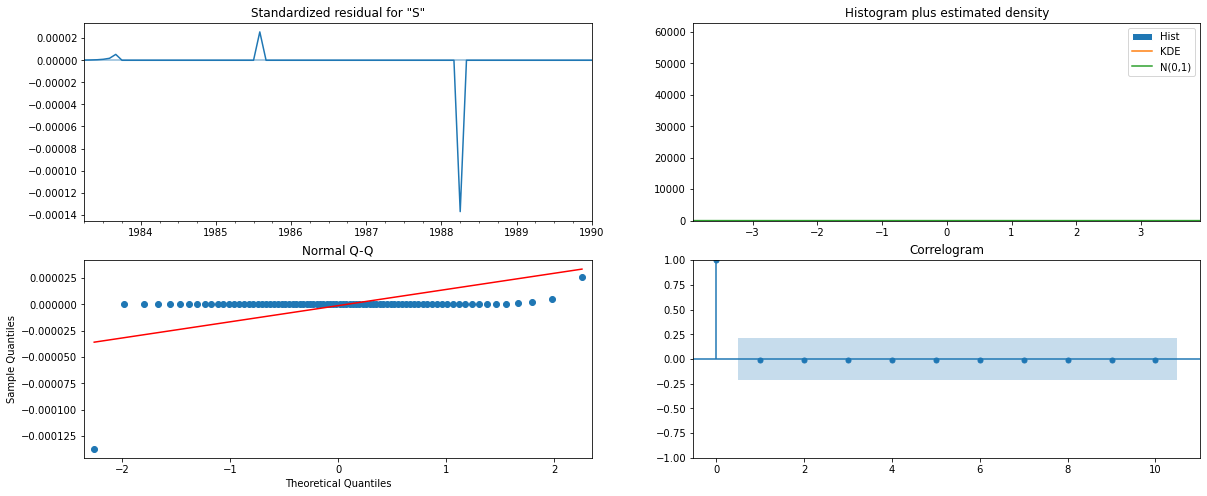

In [77]:
results_auto_SARIMA.plot_diagnostics();

## Predict on the Test Set using this model and evaluate the model.

In [78]:
predicted_auto_SARIMA = results_auto_SARIMA.forecast(steps=len(test))

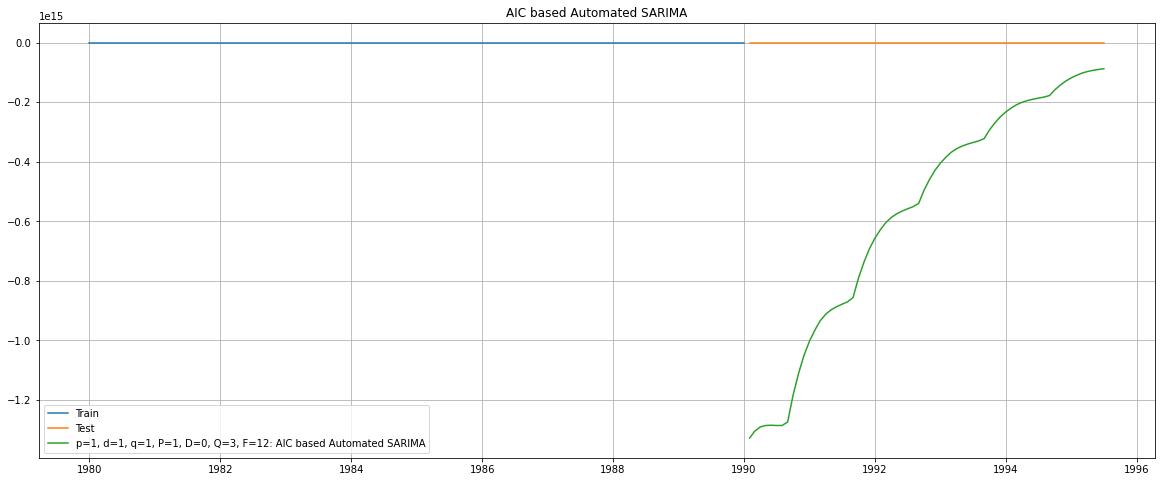

In [93]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_auto_SARIMA, label='p=1, d=1, q=1, P=1, D=0, Q=3, F=12: AIC based Automated SARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('AIC based Automated SARIMA');

In [80]:
rmse = mean_squared_error(test['Sparkling'], predicted_auto_SARIMA, squared=False)
print('RMSE:',rmse)

RMSE: 694733001166717.2


In [81]:
temp_resultsDf = pd.DataFrame({'RMSE': rmse}, index=['AUTO SARIMA (1,1,1)(1,0,3,12)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

,RMSE
LR,1.446976e+03
Naive,1.471198e+03
Average,1.298235e+03
SES (0.048),1.344345e+03
"DES ((0.076, 0.076))",1.919782e+03
"TES A (0.068, 0.035, 0.43)",4.815356e+02
"TES M (0.075, 0.064, 0.34)",4.417270e+02
"AUTO ARIMA (2, 1, 2)",1.314914e+03
"MANUAL ARIMA (3, 1, 2)",1.275004e+03
"AUTO SARIMA (1,1,1)(1,0,3,12)",6.947330e+14


## Build a version of the SARIMA model for which the best parameters are selected by looking at the ACF and the PACF plots. - Seasonality at 12.

Let us look at the ACF and the PACF plots once more.

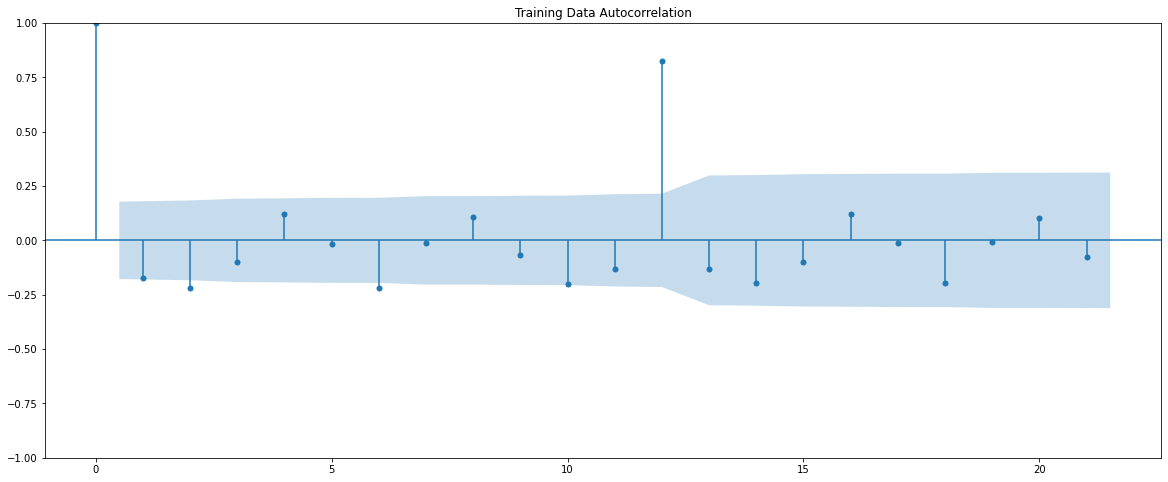

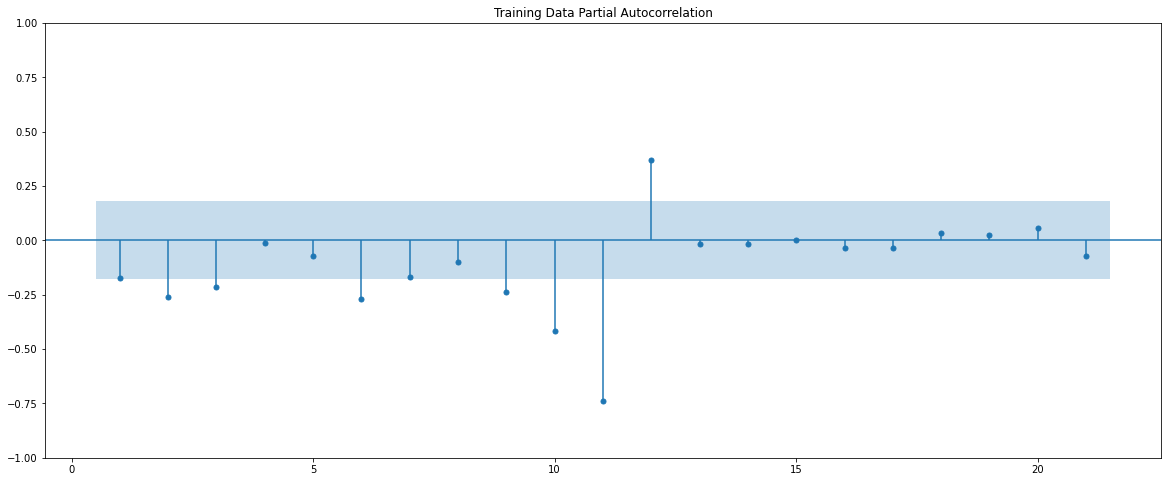

In [82]:
plot_acf(train.diff(),title='Training Data Autocorrelation',missing='drop')
plot_pacf(train.diff().dropna(),title='Training Data Partial Autocorrelation',zero=False,method='ywmle');

Here, we have taken alpha=0.05.

We are going to take the seasonal period as 12.
We are taking the p value to be 3 and the q value also to be 2 as the parameters same as the ARIMA model.

In [83]:
import statsmodels.api as sm
manual_SARIMA = sm.tsa.statespace.SARIMAX(train['Sparkling'],
                                order=(3,1,2),
                                seasonal_order=(3, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_manual_SARIMA = manual_SARIMA.fit(maxiter=1000)
print(results_manual_SARIMA.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                           Sparkling   No. Observations:                  121
Model:             SARIMAX(3, 1, 2)x(3, 0, [], 12)   Log Likelihood                -602.023
Date:                             Sat, 18 Feb 2023   AIC                           1222.047
Time:                                     17:55:08   BIC                           1243.597
Sample:                                 01-01-1980   HQIC                          1230.693
                                      - 01-01-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6226      0.267     -2.333      0.020      -1.146      -0.100
ar.L2         -0.0560      

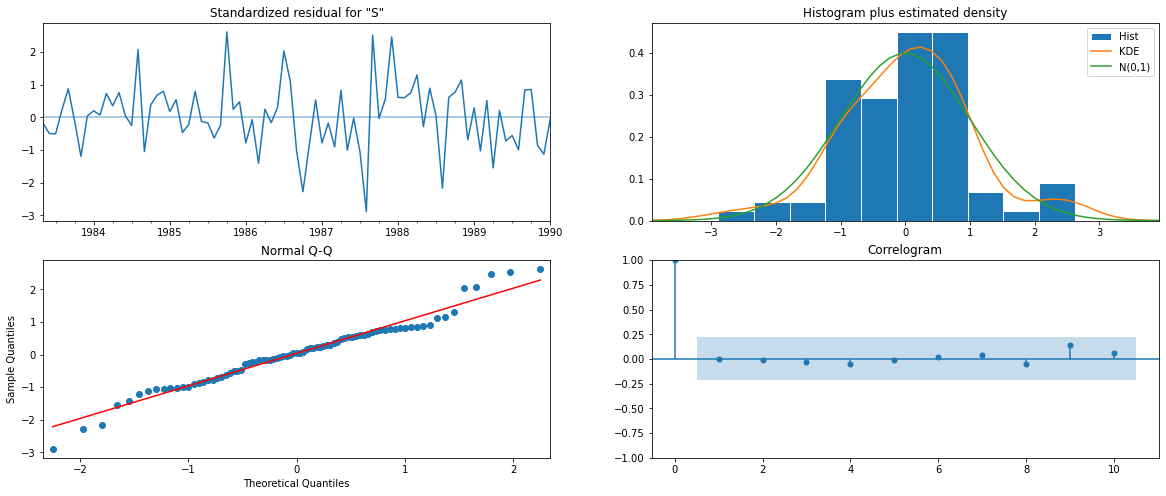

In [84]:
results_manual_SARIMA.plot_diagnostics()
plt.show()

## Predict on the Test Set using this model and evaluate the model.

In [85]:
predicted_manual_SARIMA = results_manual_SARIMA.forecast(steps=len(test))

Text(0.5, 1.0, 'ACF and PACF plots based manual SARIMA')

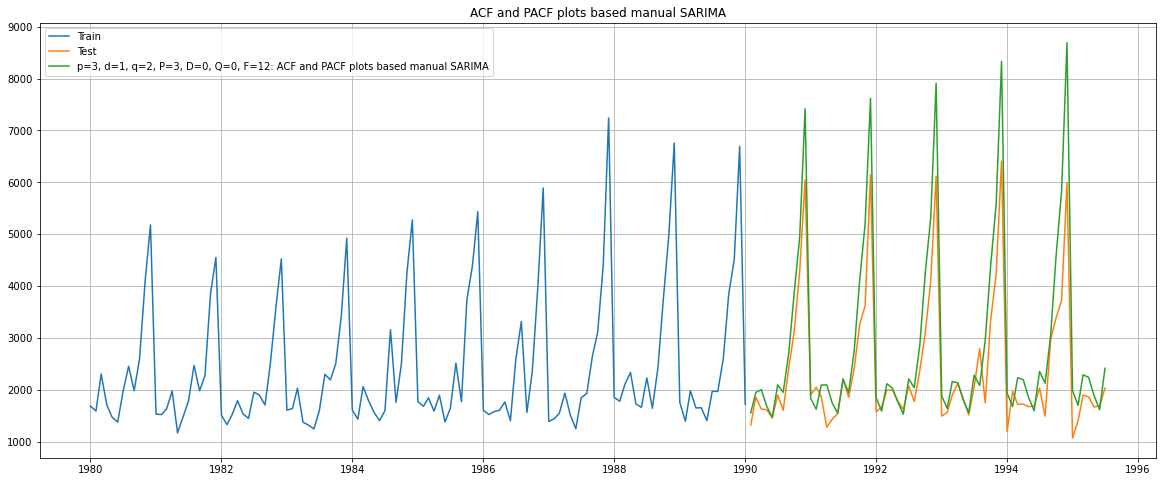

In [86]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(predicted_manual_SARIMA, label='p=3, d=1, q=2, P=3, D=0, Q=0, F=12: ACF and PACF plots based manual SARIMA')
plt.legend(loc='best')
plt.grid()
plt.title('ACF and PACF plots based manual SARIMA')

In [87]:
rmse = mean_squared_error(test['Sparkling'],predicted_manual_SARIMA,squared=False)
print('RMSE:',rmse)

RMSE: 791.0751743264723


In [88]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse]},index=['MANUAL SARIMA (3,1,2)(3,0,0,12)'])
resultsDf = pd.concat([resultsDf,temp_resultsDf])
resultsDf

,RMSE
LR,1.446976e+03
Naive,1.471198e+03
Average,1.298235e+03
SES (0.048),1.344345e+03
"DES ((0.076, 0.076))",1.919782e+03
"TES A (0.068, 0.035, 0.43)",4.815356e+02
"TES M (0.075, 0.064, 0.34)",4.417270e+02
"AUTO ARIMA (2, 1, 2)",1.314914e+03
"MANUAL ARIMA (3, 1, 2)",1.275004e+03
"AUTO SARIMA (1,1,1)(1,0,3,12)",6.947330e+14


## Building the most optimum model on the Full Data.

## Most Optimum Model is TES M

In [89]:
model_TES_am_full = ExponentialSmoothing(df,trend='add',seasonal='multiplicative',initialization_method='estimated')
model_TES_am_full = model_TES_am_full.fit()
model_TES_am_full.params

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


{'smoothing_level': 0.075673528755637,
 'smoothing_trend': 0.06486886393531484,
 'smoothing_seasonal': 0.27372628410585276,
 'damping_trend': nan,
 'initial_level': 2356.203665158414,
 'initial_trend': -17.101169323168893,
 'initial_seasons': array([0.71312236, 0.67565479, 0.88301671, 0.78979355, 0.65342823,
        0.63790824, 0.87152158, 1.13234469, 0.91171613, 1.24967493,
        1.89649585, 2.46275116]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Predict 12 months into the future.

In [90]:
predicted_TES_full_data = model_TES_am_full.forecast(steps=12)

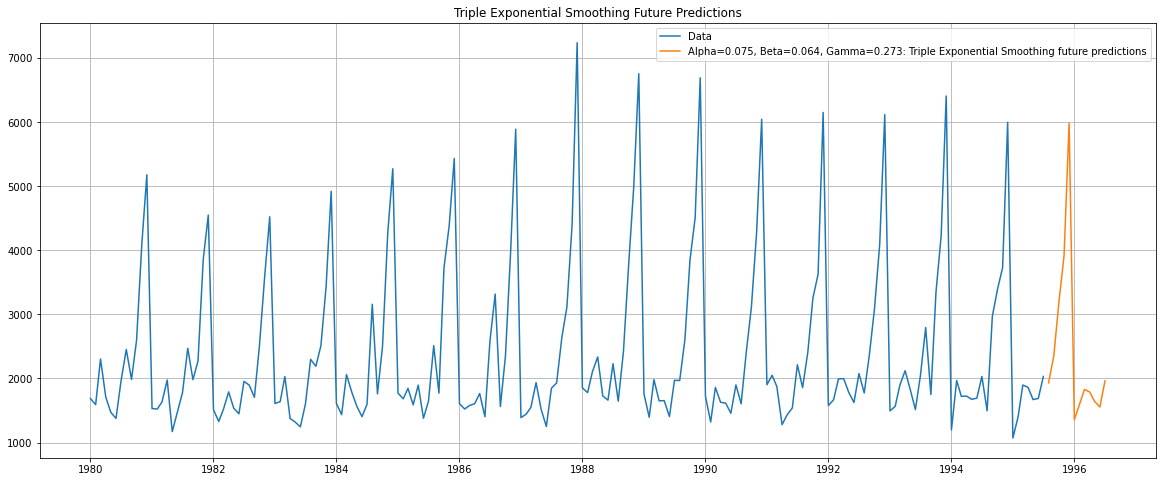

In [91]:
plt.plot(df, label='Data')
plt.plot(predicted_TES_full_data, label='Alpha=0.075, Beta=0.064, Gamma=0.273: Triple Exponential Smoothing future predictions')
plt.legend(loc='best')
plt.grid()
plt.title('Triple Exponential Smoothing Future Predictions');

In [103]:
predicted_12_month_data = predicted_TES_full_data

In [104]:
predicted_12_month_data.describe()

count      12.000000
mean     2424.040527
std      1344.191456
min      1356.447923
25%      1629.210441
50%      1880.239712
75%      2557.886206
max      5982.802931
dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

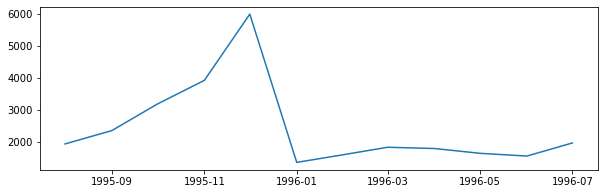

In [117]:
rcParams['figure.figsize'] = 10,3
sns.lineplot(predicted_12_month_data.index, predicted_12_month_data)


In [97]:
available_last_12_month_data = df[-12:]

In [101]:
available_last_12_month_data.describe()

,Sparkling
count,12.000000
mean,2433.000000
std,1391.572361
min,1070.000000
25%,1626.250000
50%,1879.500000
75%,3072.250000
max,5999.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='YearMonth'>

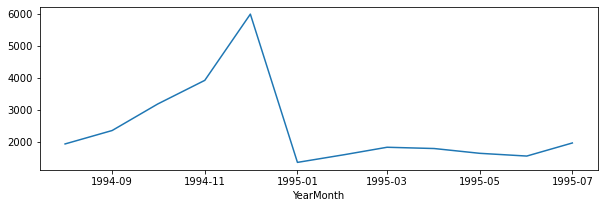

In [118]:
sns.lineplot(available_last_12_month_data.index, predicted_12_month_data)

# END